# LSTM

- reference: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Omajinai

In [52]:
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab+svg"

In [59]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout#, GRU, Bidirectional
import tensorflow as tf

## Data

In [3]:
!wget https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv -O newly_confirmed_cases_daily.csv

--2021-12-31 15:42:29--  https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv
Resolving covid19.mhlw.go.jp (covid19.mhlw.go.jp)... 54.239.143.129, 54.239.143.49, 54.239.143.31, ...
Connecting to covid19.mhlw.go.jp (covid19.mhlw.go.jp)|54.239.143.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94884 (93K) [application/octet-stream]
Saving to: ‘newly_confirmed_cases_daily.csv’

newly_confirmed_cas 100%[===================>]  92.66K  --.-KB/s    in 0.03s   

2021-12-31 15:42:30 (2.76 MB/s) - ‘newly_confirmed_cases_daily.csv’ saved [94884/94884]



In [4]:
df = pd.read_csv('newly_confirmed_cases_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)
print(df.shape)
display(df.head(1))
display(df.tail(5))

(715, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-26,225,22,0,0,0,0,0,1,2,6,...,0,0,4,3,0,0,0,0,0,21
2021-12-27,163,11,0,1,0,0,0,2,1,10,...,0,0,2,0,0,0,0,0,0,5
2021-12-28,316,20,0,0,1,0,0,1,0,23,...,0,0,7,3,1,0,0,0,0,29
2021-12-29,398,26,0,0,0,0,1,3,4,6,...,0,0,8,1,0,0,0,0,1,27
2021-12-30,437,32,0,2,0,0,0,1,1,11,...,0,0,3,2,0,0,0,0,1,50


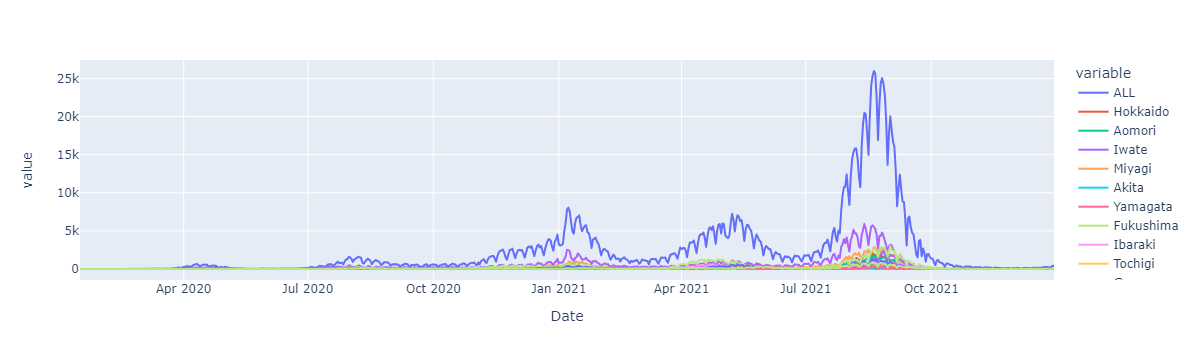

In [5]:
px.line(df, )

In [6]:
df_gr = df.groupby(pd.Grouper(level='Date', freq='W')).sum()
df_gr = df_gr.drop(df_gr.index[-1])
print(df_gr.shape)
display(df_gr.head(1))
display(df_gr.tail(5))

(102, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-19,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-28,630,66,0,0,4,0,5,2,5,1,...,3,1,42,0,0,0,1,0,0,13
2021-12-05,783,38,0,0,2,8,43,1,0,12,...,0,0,38,0,0,1,1,2,0,21
2021-12-12,803,23,3,0,3,1,7,7,14,11,...,0,0,27,0,0,0,1,0,0,24
2021-12-19,1024,52,0,0,1,0,1,1,7,11,...,0,0,16,0,0,0,0,0,9,25
2021-12-26,1551,140,0,0,2,0,1,17,12,45,...,0,0,77,3,4,1,0,0,8,127


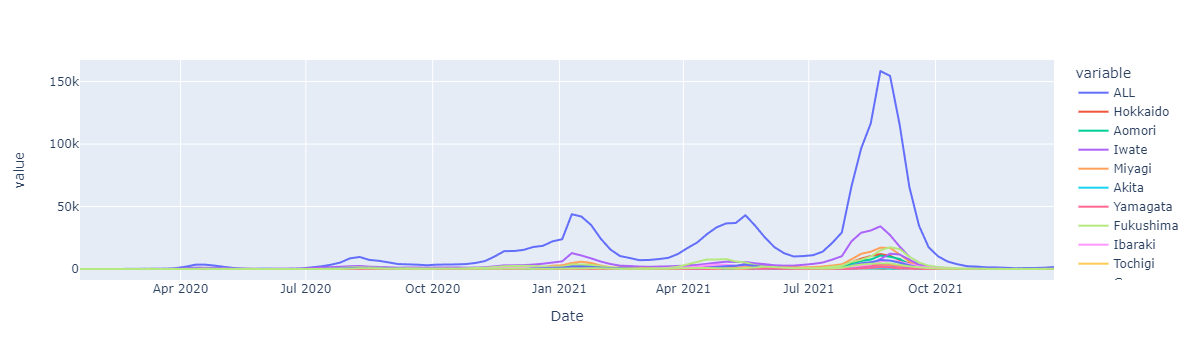

In [7]:
px.line(df_gr,)

### Scale

In [45]:
sc = MinMaxScaler(feature_range=(0,1))
ts_all = df_gr.ALL
ts_all_sc = sc.fit_transform(ts_all.values.reshape(-1, 1)).ravel()
ts_all_sc = pd.Series(ts_all_sc, index=ts_all.index)
ts_all_sc.head(1)

Date
2020-01-19    0.0
Freq: W-SUN, dtype: float64

### create X, y

In [46]:
n_timestep = 12
X = []
y = []
index_list = []
for i in range(n_timestep, ts_all_sc.shape[0]):
    X.append(ts_all_sc.values[i-n_timestep:i])
    y.append(ts_all_sc.values[i])
    index_list.append(ts_all_sc.index[i])
X = pd.DataFrame(X, index=index_list)
y = pd.Series(y, index=index_list)
print(X.shape, y.shape)
display(X.head(1))
display(y.head(1))

(90, 12) (90,)


,0,1,2,3,4,5,6,7,8,9,10,11
2020-04-12,0.0,0.000013,0.000044,0.000013,0.000088,0.00048,0.000701,0.001483,0.002007,0.001704,0.004935,0.012042


2020-04-12    0.021951
dtype: float64

## functions

In [83]:
n_units = 50
n_epochs = 10000
def trainLSTM(X_train, y_train):
    tf.random.set_seed(42)
    
    # val
    X_val = X_train[X_train.index == X_train.index[-1]]
    X_train = X_train.drop(X_train.index[-1])
    y_val = y_train[y_train.index == y_train.index[-1]]
    y_train = y_train.drop(y_train.index[-1])
    
    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    # Second LSTM layer
    model.add(LSTM(units=n_units, return_sequences=True))
    model.add(Dropout(0.2))
    # Third LSTM layer
    model.add(LSTM(units=n_units, return_sequences=True))
    model.add(Dropout(0.2))
    # Fourth LSTM layer
    model.add(LSTM(units=n_units))
    model.add(Dropout(0.2))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fitting to the training set
    history = regressor.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=n_epochs, batch_size=32, verbose=0)
    
    return model, history

## train

In [85]:
X_train = X[X.index < '2021-08-01']
y_train = y[y.index < '2021-08-01']
X_test = X[X.index >= '2021-08-01']
y_test = y[y.index >= '2021-08-01']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(68, 12) (68,) (22, 12) (22,)


7.80768968979828e-05
0.0009863415034487844
CPU times: user 16min 6s, sys: 8min 12s, total: 24min 19s
Wall time: 16min 53s


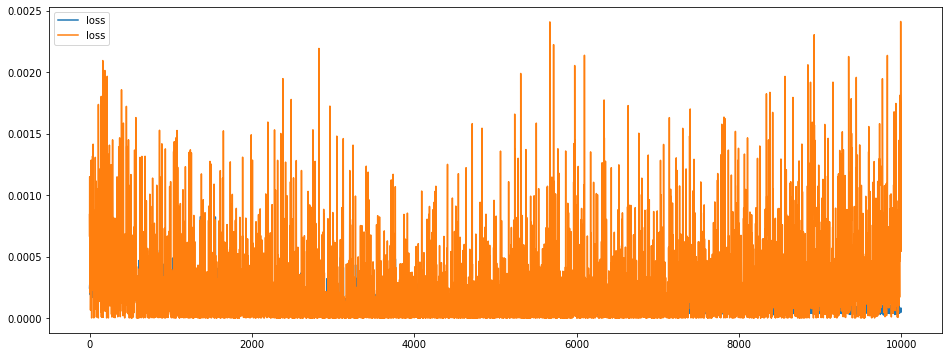

In [86]:
%%time
model, history = trainLSTM(X_train, y_train)
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

RMSE: 1.7262e+04


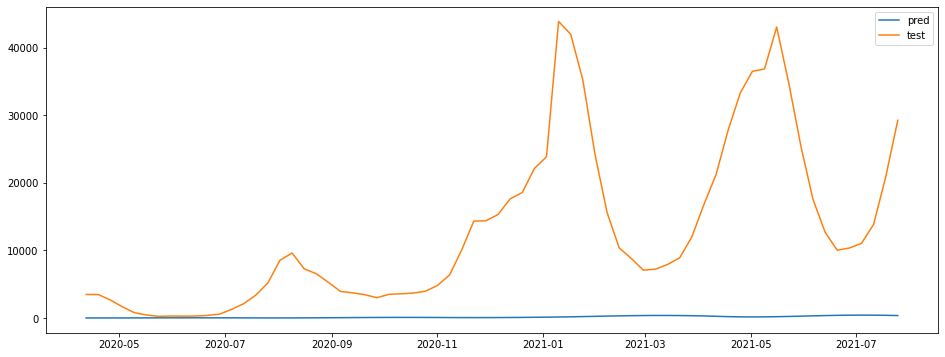

In [87]:
y_train_index = y_train.index
y_pred = model.predict(X_train)
y_pred = sc.inverse_transform(y_pred).ravel()
y_pred = pd.Series(y_pred, index=y_train_index)
y_train = sc.inverse_transform(y_train.values.reshape(-1, 1)).ravel()
y_train = pd.Series(y_train, index=y_train_bbindex)

rmse = np.sqrt( mean_squared_error(y_train, y_pred) )
print('RMSE: {:.5}'.format(rmse))

plt.plot(y_pred, label='pred')
plt.plot(y_train, label='test')
plt.legend()

RMSE: 6.5662e+04


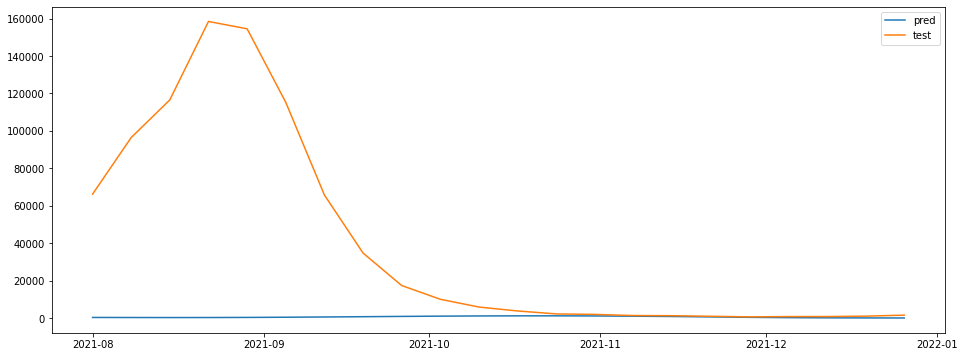

In [88]:
y_test_index = y_test.index
y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred).ravel()
y_pred = pd.Series(y_pred, index=y_test_index)
y_test = sc.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
y_test = pd.Series(y_test, index=y_test_index)

rmse = np.sqrt( mean_squared_error(y_test, y_pred) )
print('RMSE: {:.5}'.format(rmse))

plt.plot(y_pred, label='pred')
plt.plot(y_test, label='test')
plt.legend()

## benchmark

In [73]:
%%time
def auto(X, y):
    pass

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs


In [14]:
# Preparing X_test and predicting
X_test = []
index_list = []
for i in range(n_timestep, ts_test_sc.shape[0]):
    X_test.append(ts_test_sc.iloc[i-n_timestep:i])
    index_list.append(ts_test_sc.iloc[i].name)
X_test = np.array(X_test)
print(X_test.shape)

(10, 12, 1)


In [15]:
y_pred = regressor.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
ts_pred = pd.DataFrame(y_pred, index=index_list, columns=['pred'])

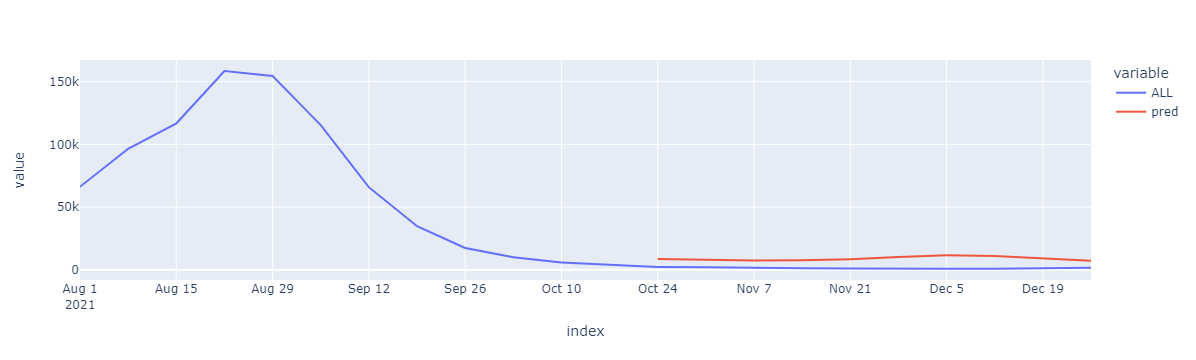

In [16]:
df_temp = pd.concat([ts_test, ts_pred], axis=1)
px.line(df_temp)